In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Problem 1

"test_broken_libc.py" *generates (x,y,z) positions with coordinates between 0 and 2^31. It introduces correlations between sequential points, with sets of points lyring on a small number of planes. It's pulled out the (x,y,z) triples with* $0<x,y,z<10^8$.

*Show that when correctly viewed, these triples lie along a set of planes (should be 30). Do this by changing the view angle or plotting ax+by, z for suitably chosen a and b. Do you see the same thing happen with python's random number generator?*

I wasn't able to get the script to work, so I used the rand_points file from github :(

In [6]:
# load points
dat = np.loadtxt('rand_points_github.txt')
x,y,z = dat[:,0], dat[:,1], dat[:,2]

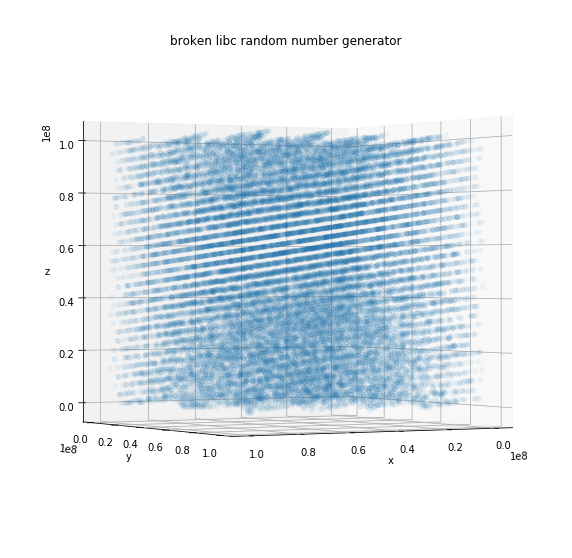

In [7]:
# plot

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(x,y,z, alpha=0.05)
ax.view_init(0, 60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('broken libc random number generator')
fig.savefig('problem1_broken_libc_random.png')

Fig: I just chose the view angle until I could see the planes. Counting along the right hand side, it looks like there are 29 planes.

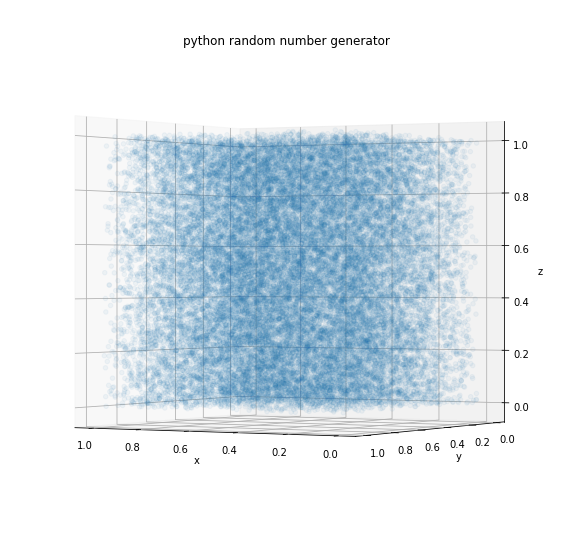

In [8]:
# python random number generator
rand = np.random.rand(dat.shape[0], dat.shape[1])
xpy, ypy, zpy = rand[:,0], rand[:,1], rand[:,2]

# plot it
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(xpy,ypy,zpy, alpha=0.05)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('python random number generator')
ax.view_init(0, 120)
fig.savefig('problem1_python_random.png')

Fig: I've tried about 10 different angles and it looks like python's random number generator doesn't introduce correlations.

# Problem 2

*Write a rejection method to generate exponential deviates from another distribution. Which of Lorentzians, Gaussians, and power laws could you use for the bounding distributions? You can assume the exponential deviates are non-negative. Show that a histogram of your deviates matches up with the expected exponential curve. How efficient can you make this generator in terms of the fraction of uniform deviates that give rise to an exponential deviate?*

The more efficient routine will be one where the (Gaussian/Lorentzian/power law) distribution is closest, while still always bounding from above, to the exponential distribution. So choose the distribution which is closest.

Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
Lorentzian tol still too high
scale Lorentzian by 1.0 for tol = 0.05


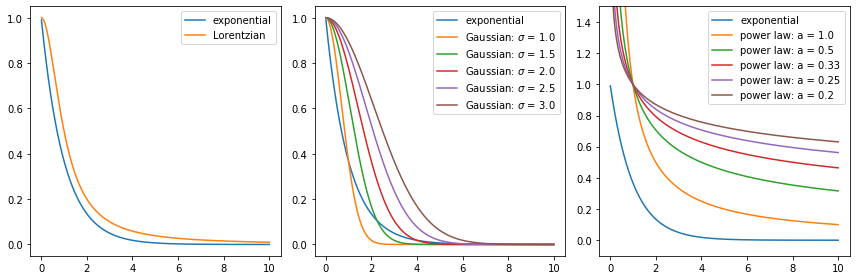

In [9]:
# get some x-values
x = np.linspace(0,10,1001)[1:]

# exponential distribution
exp = np.exp(-x)

# Lorentzian distribution
def lorentz(a,x):
    return a*(1/(1+x**2))

# find a good "a" for the Lorentzian
tol = 5e-2 
for i in range(100):
    a = 15/(i+1) # messing around with this
    lor = lorentz(a,x)
    lorentz_a = a
    if np.any(exp > lor):
        print('Lorentzian has bad bounds')
        break
    if np.sqrt(np.mean(exp - lor)**2) > tol:
        print('Lorentzian tol still too high')
    else:
        print('scale Lorentzian by {} for tol = {}'.format(a,tol))
        break

# Gaussian distribution
def gaussian(a, sigma, x):
    return a*np.exp(-x**2/sigma**2)

# power law distribution
def powerlaw(a,x):
    return x**(-a)

# plot
fig, axs = plt.subplots(1,3,figsize=(12,4), tight_layout=True)
axs.ravel()
axs[0].plot(x, exp, label='exponential')
axs[0].plot(x, lor, label='Lorentzian')
axs[1].plot(x, exp, label='exponential')

# look at some choices of Gaussians
for i in range(5):
    a = 1
    sigma = 1+0.5*(i)
    gauss = gaussian(a,sigma,x)
    axs[1].plot(x, gauss, label='Gaussian: $\sigma$ = {}'.format(np.around(sigma,2)))
axs[2].plot(x, exp, label='exponential')

# look at some choices of power laws
for i in range(5):
    a = 1/(i+1)
    powlaw = powerlaw(a,x)
    axs[2].plot(x, powlaw, label='power law: a = {}'.format(np.around(a,2)))
    
# last plot things
axs[2].set_ylim(-0.1,1.5)
for i in range(3):
    axs[i].legend()
fig.savefig('problem2_choosing_distributions.png')

Fig: For a RMS difference of 0.05, the (unscaled) Lorentzian bounds the exponential. For the Gaussian, I would need to make $\sigma$ large to not have it cross over the exponential, which would make this distribution less efficient than the Lorentzian. The power laws are also all bad choices: for $a=1$, it's overshooting the exponential at low x and for $a<1$ it's overshooting at higher x. So I'll use the Lorentzian.

Then draw samples from the Lorentzian (integrate to get the CDF and invert) and see if they're larger than the exponential. If they are larger then reject them.

The integral of the Lorentzian is $\int_0^x \frac{1}{1+y^2}dy = arctan(y) | ^x_0 = arctan(x) - 0 $.

Invert to solve for $x$ with random number $r$ in $r = arctan(x) \rightarrow x = tan(r)$, $r \in (-\pi/2, \pi/2)$

I'm trying to base this code off "rand_arctan.py" (from 2022) with a few lines from "gauss_rejection_class.py" (from 2021) but I'm not following a couple steps. In particular, I had to scale the Lorentzian and multiply it by a random number to get the histogram to match the shape of the exponential and even then, it looks like the exponential isn't bounding the distribution from above like it should.

accepted 68.0612% of samples from Lorentzian


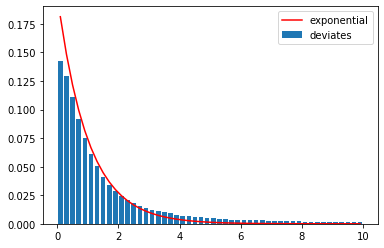

In [10]:
# take n random numbers
n = int(1e6)

# get the r values, they should be bounded by +/- pi/2
r = np.pi*(np.random.rand(n)-0.5)

# get the exponential evaluated at the random numbers
myp = np.exp(-r)

# accept the random numbers if they're less than the exponential
accept= r<np.exp(-r)
print('accepted {}% of samples from Lorentzian'.format(100*np.sum(accept)/n))

# scale the Lorentzian - this bit confuses me
new_lorentz_a = 6*np.random.rand(n)
y = lorentz(new_lorentz_a, r)

# only use the Lorentzian evaluated
# at the accepted random numbers
y_use=y[accept]

# get the final deviates
x_use=np.tan(y_use)

# histogram
aa,bb=np.histogram(x_use,np.linspace(0,10,51))
aa=aa/aa.sum() # normalize

# plot against the bin centers
b_cent=0.5*(bb[1:]+bb[:-1])

# exponential distribution evaluated at bin centers
pred= np.exp(-b_cent)
pred=pred/pred.sum() # normalize

# plot
plt.figure()
plt.bar(b_cent, aa, 0.15, label='deviates')
plt.plot(b_cent, pred, c='r', label='exponential')
plt.legend()
plt.savefig('problem2_deviates_histogram.png')

# Problem 3

*Repeat problem 2 but use a ratio-of-uniforms generator. If u goes from 0 to 1, what are the limits on v? How efficient is this generator, in terms of exponential deviates produced per uniform deviate? Plot the histogram again and show the answer is still correct.*

So this problem doesn't use a Lorentzian, but we uniformly sample from a $(u,v)$ plane (draw random numbers $u$ and $v$ using random.rand). $u$ is bounded by 0 and $\sqrt{exp(-v/u)}$. If the sample falls within the probability region then return $r =v/u$.  

If $u_{max}=1$ then $1 = \sqrt{exp(-v)}$ so $v = 0$. 

If $u_{min}=0$ then $0 = \sqrt{exp(-v/u)}$ then $v \rightarrow \infty$ so $v$ isn't bounded from above.

accepted 50.0% of u, v


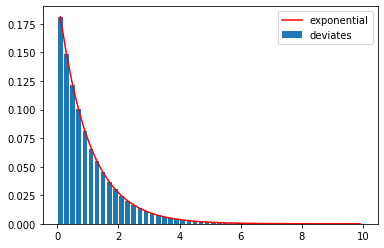

In [13]:
# get random u,v
n = int(1e6)
u = np.random.rand(n)
v = np.random.rand(n)

# accept if u is between 0 and sqrt(exp(-v/u))
accept = (u>=0)&(u<=np.sqrt(np.exp(-v/u)))
u_use = u[accept]
v_use = v[accept]
print('accepted {}% of u, v'.format(np.around(np.sum(accept)/n*100),2))

# return r
r = v_use/u_use

# histogram
aa,bb = np.histogram(r, np.linspace(0,10,51))
aa = aa/aa.sum() # normalize

# bin centers
b_cent =0.5*(bb[1:]+bb[:-1])

# predicted exponential distribution
pred = np.exp(-b_cent)
pred = pred/pred.sum() # normalize

# plot
plt.figure()
plt.clf()
plt.plot(b_cent,pred,'r', label='exponential')
plt.bar(b_cent,aa,0.15, label='deviates')
plt.legend()
plt.savefig('problem3_uniform')

Fig: This is less efficient (accepted 50%, whereas 68% was accepted for problem 2), but now the bounding looks like it should. Maybe problem 2 has a mistake and should be less efficient? (I tried scaling down $v$ to make it more efficient but then the distributions don't match).